In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
# EDIT: decided to track how long each epoch takes
import time
import gzip
import os
import struct

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# repeating the data prep from the previous notebook
NROWS = 28
NCOLS = 28


DATASET_DIR = ""
MNIST_TRAIN_IMS_GZ = os.path.join(DATASET_DIR, "train-images-idx3-ubyte.gz")
MNIST_TRAIN_LBS_GZ = os.path.join(DATASET_DIR, "train-labels-idx1-ubyte.gz")
MNIST_TEST_IMS_GZ = os.path.join(DATASET_DIR, "t10k-images-idx3-ubyte.gz")
MNIST_TEST_LBS_GZ = os.path.join(DATASET_DIR, "t10k-labels-idx1-ubyte.gz")

def load_data():
    print("Unpacking training images ...")
    with gzip.open(MNIST_TRAIN_IMS_GZ, mode='rb') as f:
        magic_num, train_sz, nrows, ncols = struct.unpack('>llll', f.read(16))
        print("magic number: %d, num of examples: %d, rows: %d, columns: %d" % (magic_num, train_sz, nrows, ncols))
        data_bn = f.read()
        data = struct.unpack('<'+'B'*train_sz*nrows*ncols, data_bn)
        train_ims = np.asarray(data)
        train_ims = train_ims.reshape(train_sz, nrows*ncols)
    print("~"*5)

    print("Unpacking training labels ...")
    with gzip.open(MNIST_TRAIN_LBS_GZ, mode='rb') as f:
        magic_num, train_sz = struct.unpack('>ll', f.read(8))
        print("magic number: %d, num of examples: %d" % (magic_num, train_sz))
        data_bn = f.read()
        data = struct.unpack('<'+'B'*train_sz, data_bn)
        train_lbs = np.asarray(data)
        print("~"*5)

    print("Unpacking test images ...")
    with gzip.open(MNIST_TEST_IMS_GZ, mode='rb') as f:
        magic_num, test_sz, nrows, ncols = struct.unpack('>llll', f.read(16))
        print("magic number: %d, num of examples: %d, rows: %d, columns: %d" % (magic_num, train_sz, nrows, ncols))
        data_bn = f.read()
        data = struct.unpack('<'+'B'*test_sz*nrows*ncols, data_bn)
        test_ims = np.asarray(data)
        test_ims = test_ims.reshape(test_sz, nrows*ncols)
    print("~"*5)

    print("Unpacking test labels ...")
    with gzip.open(MNIST_TEST_LBS_GZ, mode='rb') as f:
        magic_num, test_sz = struct.unpack('>ll', f.read(8))
        print("magic number: %d, num of examples: %d" % (magic_num, train_sz))
        data_bn = f.read()
        data = struct.unpack('<'+'B'*test_sz, data_bn)
        test_lbs = np.asarray(data)
    print("~"*5)

    return train_ims, train_lbs, test_ims, test_lbs

x_train, y_train, x_test, y_test = load_data()


#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# EDIT: splitting training data into train and val because this is better practice than using test data to
# choose models/hyperparameters
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

x_train = x_train.astype(np.float32)
# EDIT: adding pre-processing to validation data 
x_val  = x_val.astype(np.float32)
x_test  = x_test.astype(np.float32)

x_train /= 255.
x_val  /= 255.
x_test  /= 255.

print(x_train.shape)
#x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
#x_val = x_val.reshape(x_val.shape[0], numpy.prod(x_val[0,:,:].shape))
#x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
#y_train = y_train.astype(numpy.int32)
#y_val  = y_val.astype(numpy.int32)
#y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'val:',len(x_val), 'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

Unpacking training images ...
magic number: 2051, num of examples: 60000, rows: 28, columns: 28
~~~~~
Unpacking training labels ...
magic number: 2049, num of examples: 60000
~~~~~
Unpacking test images ...
magic number: 2051, num of examples: 60000, rows: 28, columns: 28
~~~~~
Unpacking test labels ...
magic number: 2049, num of examples: 60000
~~~~~
(40200, 784)
(40200, 784)

MNIST data loaded: train: 40200 val: 19800 test: 10000
X_train: (40200, 784)
y_train: (40200,)


Since the internet does not work on jupytor notebook in my case, so I manually download the mnist set first and unzip those files!

In [5]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [6]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights

In [7]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    sgd(model, gradients, learning_rate)
    return loss

In [8]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = np.argmax(scores, axis=1)
    N = predictions.shape[0]
    # EDIT: squeezing true_values from 2d to 1d speeds up this function
    true_values_1d = np.squeeze(true_values)
    acc = (true_values_1d == predictions).sum() / N
    return acc

In [9]:
# Here's an example training loop using this two-layer model. Can you do better? 

# EDIT: also track validation data
# EDIT: factoring this out into a function to make it easier to compare options
def training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses = np.zeros((num_batches_train*num_epochs,2)) # 1st column for training data, 2nd for validation data
    # EDIT: also track accuracy
    accuracies = np.zeros((num_batches_train*num_epochs,2)) 
    
    indices_train = np.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = np.arange(num_examples_val)

    i = 0
    for epoch in range(0, num_epochs):
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,np.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = np.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,np.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses[i,0] = loss_train
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies[i,0] = accuracy(model, x_train_batch, y_train_batch)
            losses[i,1], _ = model.loss(x_val_batch, y_val_onehot_batch)
            accuracies[i,1] = accuracy(model, x_val_batch, y_val_batch)
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        np.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        np.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
    return losses, accuracies, model

        

epoch 0 took 5.5 seconds, training loss 2.30263 (last batch), training accuracy 0.091, validation accuracy 0.092
epoch 1 took 4.5 seconds, training loss 2.30166 (last batch), training accuracy 0.107, validation accuracy 0.109
epoch 2 took 4.9 seconds, training loss 2.30064 (last batch), training accuracy 0.128, validation accuracy 0.130
epoch 3 took 5.2 seconds, training loss 2.29962 (last batch), training accuracy 0.154, validation accuracy 0.157
epoch 4 took 6.3 seconds, training loss 2.29881 (last batch), training accuracy 0.184, validation accuracy 0.185
epoch 5 took 6.6 seconds, training loss 2.29771 (last batch), training accuracy 0.217, validation accuracy 0.218
epoch 6 took 6.5 seconds, training loss 2.29653 (last batch), training accuracy 0.248, validation accuracy 0.248
epoch 7 took 6.3 seconds, training loss 2.29568 (last batch), training accuracy 0.278, validation accuracy 0.280
epoch 8 took 6.4 seconds, training loss 2.29446 (last batch), training accuracy 0.308, validatio

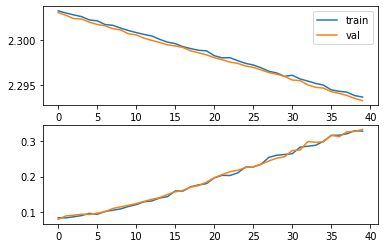

In [10]:
# these are the hyperparameters we had in class
learning_rate = 0.01  
batch_size = 10000
num_epochs = 10
hidden_dim = 300
weight_scale = .01
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

# EDIT: plot training & val, loss & accuracy
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

The default setting will get around 0.3 accuracy and 2 loss. However, the training and validation result are very close to each other, which means that they don't have overfitting or underfitting issue, so we only have to worry about the parameter adjusting until the loss converge! 

In [11]:
# Here's an example training loop using this two-layer model. Can you do better? 

# EDIT: also track validation data
# EDIT: factoring this out into a function to make it easier to compare options
def training(learning_rate, batch_size, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses_train = [] #for training data, 
    losses_test = [] #validation data
    # EDIT: also track accuracy
    accuracies_train = []
    accuracies_test = []
    
    indices_train = np.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = np.arange(num_examples_val)

    i = 0
    #for epoch in range(0, num_epochs):
    loss_train = 100
    epoch = 0
    while loss_train > 0.5:
        epoch = epoch + 1
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,np.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = np.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,np.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses_train.append(loss_train)
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies_train.append(accuracy(model, x_train_batch, y_train_batch))
            loss_val, _ = model.loss(x_val_batch, y_val_onehot_batch)
            losses_test.append(loss_val)
            accuracies_test.append(accuracy(model, x_val_batch, y_val_batch))
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        np.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        np.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
        if loss_train < 0.5:
            break
    return losses_train, losses_test, accuracies_train, accuracies_test, model

epoch 1 took 4.9 seconds, training loss 2.29892 (last batch), training accuracy 0.242, validation accuracy 0.240
epoch 2 took 5.2 seconds, training loss 2.29379 (last batch), training accuracy 0.362, validation accuracy 0.363
epoch 3 took 5.5 seconds, training loss 2.28837 (last batch), training accuracy 0.441, validation accuracy 0.437
epoch 4 took 6.0 seconds, training loss 2.28280 (last batch), training accuracy 0.488, validation accuracy 0.489
epoch 5 took 6.5 seconds, training loss 2.27589 (last batch), training accuracy 0.520, validation accuracy 0.519
epoch 6 took 6.5 seconds, training loss 2.26875 (last batch), training accuracy 0.538, validation accuracy 0.538
epoch 7 took 6.6 seconds, training loss 2.26052 (last batch), training accuracy 0.549, validation accuracy 0.549
epoch 8 took 6.5 seconds, training loss 2.25021 (last batch), training accuracy 0.556, validation accuracy 0.556
epoch 9 took 6.3 seconds, training loss 2.23973 (last batch), training accuracy 0.560, validatio

epoch 73 took 5.0 seconds, training loss 0.56991 (last batch), training accuracy 0.856, validation accuracy 0.855
epoch 74 took 5.0 seconds, training loss 0.57279 (last batch), training accuracy 0.857, validation accuracy 0.857
epoch 75 took 5.3 seconds, training loss 0.56083 (last batch), training accuracy 0.858, validation accuracy 0.858
epoch 76 took 5.1 seconds, training loss 0.57101 (last batch), training accuracy 0.859, validation accuracy 0.859
epoch 77 took 5.2 seconds, training loss 0.55392 (last batch), training accuracy 0.860, validation accuracy 0.860
epoch 78 took 5.3 seconds, training loss 0.55240 (last batch), training accuracy 0.861, validation accuracy 0.861
epoch 79 took 5.2 seconds, training loss 0.54311 (last batch), training accuracy 0.862, validation accuracy 0.862
epoch 80 took 5.2 seconds, training loss 0.54912 (last batch), training accuracy 0.863, validation accuracy 0.863
epoch 81 took 5.2 seconds, training loss 0.54199 (last batch), training accuracy 0.864, 

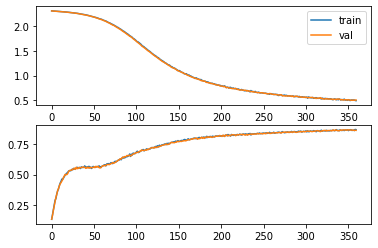

In [12]:
# these are the hyperparameters we had in class
learning_rate = 0.05  
batch_size = 10000
num_epochs = 50
hidden_dim = 300
weight_scale = .01
losses_train, losses_test, accuracies_train, accuracies_test, model = training(learning_rate, batch_size, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

# EDIT: plot training & val, loss & accuracy
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses_train)
plt.plot(losses_test)
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies_train)
plt.plot(accuracies_test)

I set the desired loss below 0.5 in the train function, so that we don't have to set the number of epochs. Also, I update the learning rate from 0.01 to 0.05 so it can reduce the training step.